In [82]:
import os, sys, json
import scipy.stats
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [83]:
from datasets import load_dataset

In [84]:
dataset = load_dataset("yelp_review_full")

In [85]:
dataset_test = dataset["test"]

In [86]:
def test_significance(df_train, metric1, metric2):
    correlation, p_value = scipy.stats.spearmanr(df_train[metric1], df_train[metric2])
    print(f'Correlation between {metric1} and {metric2}')
    print(f"Correlation coefficient: {correlation}")
    print(f"P-value: {p_value}")
    significant = False
    if p_value < 0.05:
        significant = True 
    return {
                    "metric1": metric1,
                    "metric2": metric2,
                    "correlation": correlation, 
                    "p-value": p_value, 
                    "signficant": significant
                }

def plot(df_train, column1, column2, prefix='Raw'):
    plt.figure(figsize=(8, 6))  
    # plt.scatter(df_train[column1], df_train[column2], color='blue', alpha=0.6) 
    sns.regplot(x = df_train[column1], y = df_train[column2], color='green', scatter_kws={'alpha':0.5})
    plt.title(f'Scatter Plot of {column1} vs {column2} on {prefix}')  
    plt.xlabel(f'{column1}')  
    plt.ylabel(f'{column2}')  
    plt.grid(True) 
    plt.savefig(f'./{column1}_{column2}_{prefix}_correlation.png', dpi=300)

In [87]:
# convert to json
data = []
for i in range(len(dataset_test)):
    data.append({"text": dataset_test[i]["text"], "gt_label": dataset_test[i]["label"]})

In [88]:
data_df = {x['text']: x for x in data}

In [89]:
path_predicted_labels = "/home/anmola/assignments_hw/sentiment-cartography/v2_dir_512_large/inference_results.json"
path_logit_scores = "/home/anmola/assignments_hw/sentiment-cartography/single_v2_dir_512_large/inference_results.json"

In [90]:
with open(path_predicted_labels, "r") as f:
    predicted_df = json.load(f)
with open(path_logit_scores, "r") as f:
    logit_df = json.load(f)

In [91]:
def find_matched_pairs(s1, arr_s):
    # find indexes of all elements in arr_s that s1 is a substring of
    matched_pairs = []
    for i, s in enumerate(arr_s):
        if s1 in s:
            matched_pairs.append(i)
    assert(len(matched_pairs) > 0)
    assert(len(matched_pairs)==1)
    return matched_pairs

In [92]:
all_keys = list(data_df.keys())
for elem in tqdm.tqdm(predicted_df):
    curr_review_text = elem["review"]
    if curr_review_text in data_df:
        matched_review_text = curr_review_text
    else:
        matched_key_idx = find_matched_pairs(curr_review_text, all_keys)
        matched_review_text = all_keys[matched_key_idx[0]]
    assert("multi_class_predicted_label" not in data_df[matched_review_text])
    data_df[matched_review_text]["multiclass_predicted_label"] = elem["predicted_label"]

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:21<00:00, 2309.91it/s]


In [93]:
for elem in tqdm.tqdm(logit_df):
    curr_review_text = elem["review"]
    if curr_review_text in data_df:
        matched_review_text = curr_review_text
    else:
        matched_key_idx = find_matched_pairs(curr_review_text, all_keys)
        matched_review_text = all_keys[matched_key_idx[0]]
    assert("single_class_logit_score" not in data_df[matched_review_text])
    logits = elem["logit_scores"]
    softmax_scores = scipy.special.softmax(logits)
    assert(len(softmax_scores) == 2)
    data_df[matched_review_text]["single_class_logit_score"] = softmax_scores[1]
    #break

100%|██████████| 50000/50000 [00:23<00:00, 2159.12it/s]


In [94]:
softmax_scores
logits

[1.385589599609375, -0.9600492715835571]

In [95]:
# convert elements of data_df to a list
data_list = [data_df[x] for x in data_df]
# make dataframes
import pandas as pd
df = pd.DataFrame(data_list)


Correlation between gt_label and multiclass_predicted_label
Correlation coefficient: 0.8457933062696361
P-value: 0.0


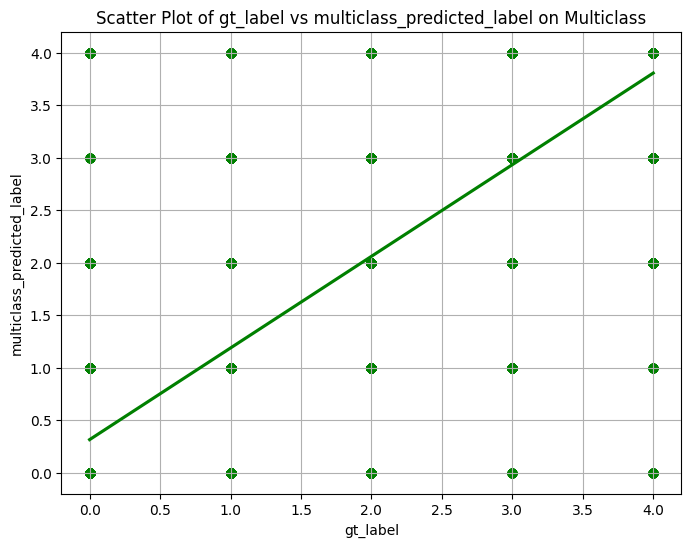

In [96]:
metric_1 = "gt_label"
metric_2 = "multiclass_predicted_label"
result = test_significance(df, metric_1, metric_2)
plot(df, metric_1, metric_2, prefix='Multiclass')

Correlation between gt_label and single_class_logit_score
Correlation coefficient: 0.8445710317055284
P-value: 0.0


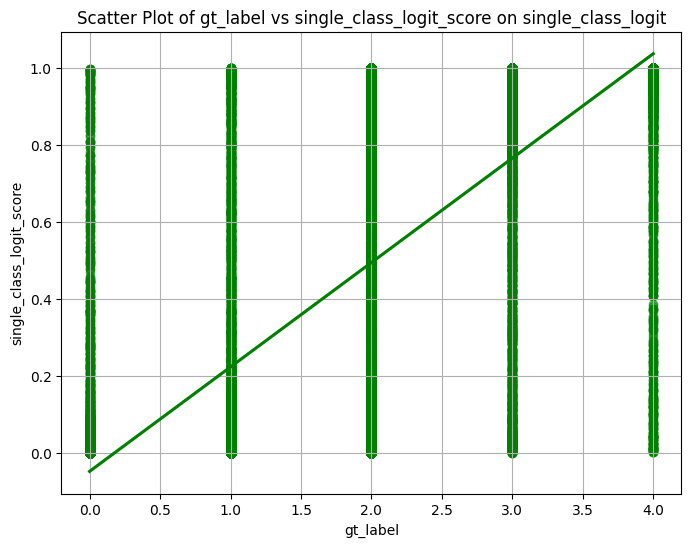

In [97]:
metric_1 = "gt_label"
metric_2 = "single_class_logit_score"
result = test_significance(df, metric_1, metric_2)
plot(df, metric_1, metric_2, prefix='single_class_logit')

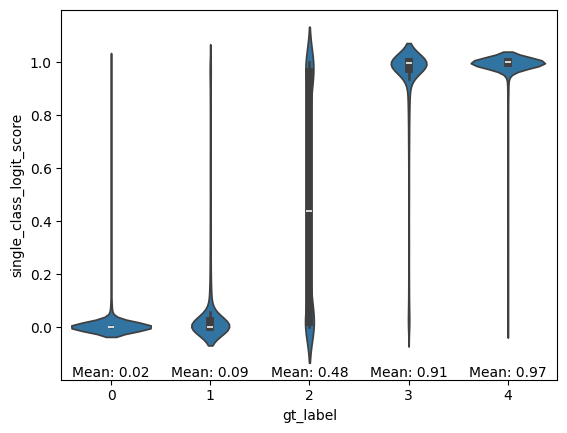

In [107]:
metric_1 = "gt_label"
metric_2 = "single_class_logit_score"
# for each category in gt_label, make a histogram on the same plot
sns.violinplot(x=df["gt_label"], y=df["single_class_logit_score"])

# annotate means and std-dev
grouped = df.groupby("gt_label")
means = grouped["single_class_logit_score"].mean()
stds = grouped["single_class_logit_score"].std()
for i, mean in enumerate(means):
    plt.text(i, -0.2, f'Mean: {mean:.2f}', ha='center', va='bottom')


<Axes: xlabel='Predicted', ylabel='Actual'>

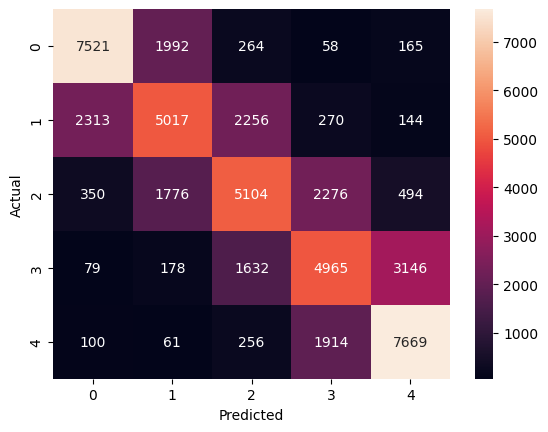

In [109]:
metric_1 = "gt_label"
metric_2 = "multiclass_predicted_label"
# make confusion matrix with fractions
confusion_matrix = pd.crosstab(df[metric_1], df[metric_2], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d')
